# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
%%pycodestyle


class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init

        if self.metric == 'euclidean':
            self.pwdistance = self._euc_dist
            self.simpledistance = self._simple_euc_dist

    def _euc_dist(self, X, centroids):
        return np.sqrt(np.sum((centroids[None, :] - X[:, None])**2, -1))

    def _simple_euc_dist(self, X, centroids, n):
        return np.sqrt(np.sum((X - centroids[n, :]) ** 2, axis=1))

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], np.uint8)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        newcentroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        # ...

        if self.init == 'random':
            # Random centroids init
            self.centroids = np.copy(X)
            np.random.shuffle(self.centroids)
            self.centroids = self.centroids[:self.k, :]
        if self.init == 'k-means':
            # k-means++ init
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0, :] = X[np.random.randint(0, X.shape[0]), :]
            for i in range(1, self.k):
                dist = np.empty((self.k, X.shape[0]))
                for j in range(self.k):
                    dist[j, :] = self.simpledistance(X, self.centroids, j)
                dist = np.min(dist, axis=0)
                dist = np.cumsum(dist / np.sum(dist))
                pos = np.random.sample()
                self.centroids[i, :] = X[dist[dist < pos].size, :]

        # Break conditions
        trig = True
        iters = 0

        # Algorithm
        while trig and (iters < self.max_iter):
            trig = False

            # Labeling
            pwd = self.pwdistance(X, self.centroids)
            self.labels = np.argsort(pwd, axis=1)[:, 0]

            # Counting new centroids
            for i in range(self.k):
                ithcluster = X[self.labels == i]
                newcentroids[i] = np.sum(ithcluster, axis=0)
                newcentroids[i] /= ithcluster.shape[0]
                if not trig:
                    if np.sum((newcentroids[i] - self.centroids[i])**2) > 0.:
                        trig = True

            # Refreshing centroids
            self.centroids = newcentroids

            iters += 1

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        pwd = self.pwdistance(X, self.centroids)
        labels = np.argsort(pwd, axis=1)[:, 0]

        return labels


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=16):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        :batch_size - размер батча
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.batch_size = batch_size

        if self.metric == 'euclidean':
            self.pwdistance = self._euc_dist
            self.simpledistance = self._simple_euc_dist

    def _euc_dist(self, X, centroids):
        return np.sqrt(np.sum((centroids[None, :] - X[:, None])**2, -1))

    def _simple_euc_dist(self, X, centroids, n):
        return np.sqrt(np.sum((X - centroids[n, :]) ** 2, axis=1))

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], np.uint8)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        newcentroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        # ...

        if self.init == 'random':
            # Random centroids init
            self.centroids = np.copy(X)
            np.random.shuffle(self.centroids)
            self.centroids = self.centroids[:self.k, :]
        if self.init == 'k-means':
            # k-means++ init
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0, :] = X[np.random.randint(0, X.shape[0]), :]
            for i in range(1, self.k):
                dist = np.empty((self.k, X.shape[0]))
                for j in range(self.k):
                    dist[j, :] = self.simpledistance(X, self.centroids, j)
                dist = np.min(dist, axis=0)
                dist = np.cumsum(dist / np.sum(dist))
                pos = np.random.sample()
                self.centroids[i, :] = X[dist[dist < pos].size, :]

        # Break conditions
        trig = True
        iters = 0

        # Algorithm
        while trig and (iters < self.max_iter):
            trig = False

            # Masking batch
            batch_mask = np.random.choice(np.arange(X.shape[0]),
                                          self.batch_size)

            # Labeling
            pwd = self.pwdistance(X[batch_mask, :], self.centroids)
            self.labels[batch_mask] = np.argsort(pwd, axis=1)[:, 0]

            # Counting new centroids
            for i in range(self.k):
                ithcluster = X[batch_mask][self.labels[batch_mask] == i]
                newcentroids[i] = np.sum(ithcluster, axis=0)
                newcentroids[i] /= ithcluster.shape[0]
                if not trig:
                    if np.sum((newcentroids[i] - self.centroids[i])**2) > 0.:
                        trig = True

            # Refreshing centroids
            self.centroids = newcentroids

            iters += 1

        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs


In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)


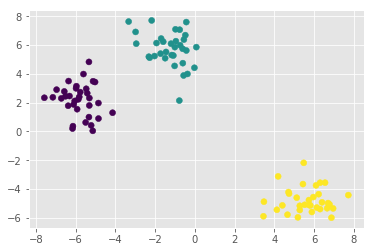

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)


Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

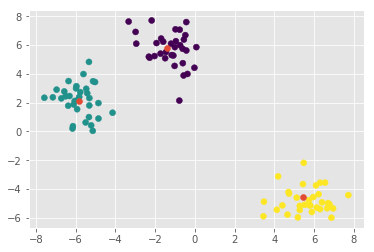

In [6]:
## Работоспособность MyKmeans
km = MyKmeans(k=3)
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


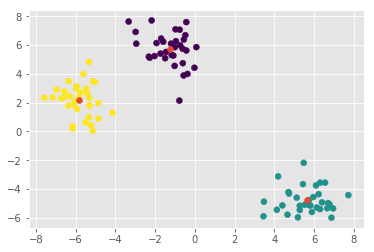

In [7]:
## Работоспособность MyKmeans++
km = MyKmeans(k=3, init='k-means')
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


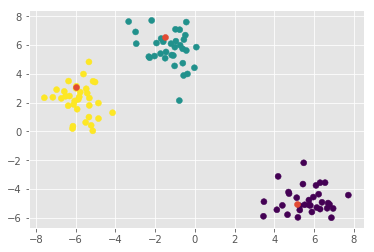

In [8]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
km = MiniBatchKMeans(k=3)
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning: overflow encountered in square


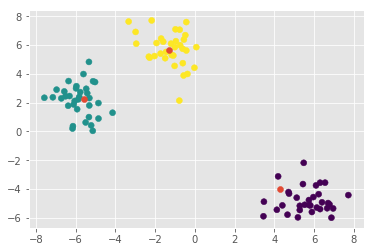

In [9]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
km = MiniBatchKMeans(k=3, init='k-means')
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


Text(0,0.5,'time')

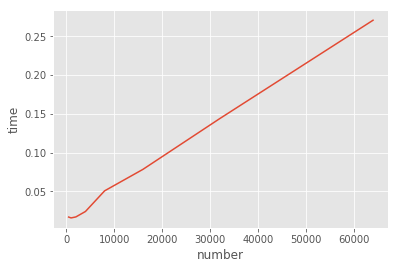

In [10]:
## Время выполнения алгоритма Kmeans из sklearn
import time
from sklearn.cluster import KMeans
sizes = [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]
t1 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = KMeans(n_clusters=3)
    tau = time.time()
    km.fit(X)
    t1[i] = time.time() - tau
plt.plot(sizes, t1)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

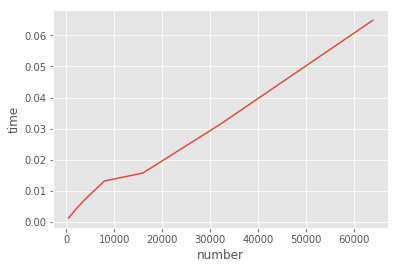

In [11]:
## Время выполнения алгоритма MyKmeans
t2 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MyKmeans(k=3, max_iter=300)
    tau = time.time()
    km.fit(X)
    t2[i] = time.time() - tau
plt.plot(sizes, t2)
plt.xlabel('number')
plt.ylabel('time')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in square


Text(0,0.5,'time')

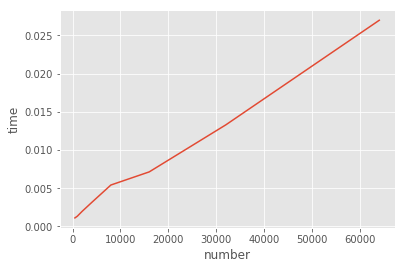

In [12]:
## Время выполнения алгоритма MyKmeans++
t3 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MyKmeans(k=3, max_iter=300, init='k-means')
    tau = time.time()
    km.fit(X)
    t3[i] = time.time() - tau
plt.plot(sizes, t3)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

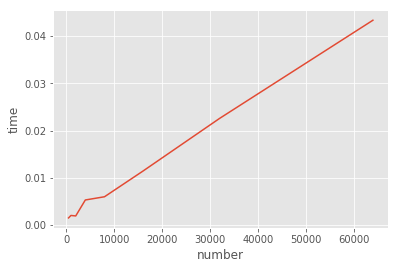

In [13]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
t4 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MiniBatchKMeans(k=3, max_iter=300, batch_size=100)
    tau = time.time()
    km.fit(X)
    t4[i] = time.time() - tau
plt.plot(sizes, t4)
plt.xlabel('number')
plt.ylabel('time')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in divide


Text(0,0.5,'time')

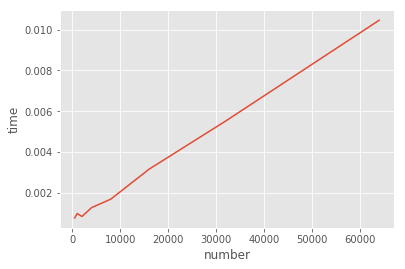

In [14]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
t5 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MiniBatchKMeans(k=3, max_iter=300, init='k-means', batch_size=100)
    tau = time.time()
    km.fit(X)
    t5[i] = time.time() - tau
plt.plot(sizes, t5)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

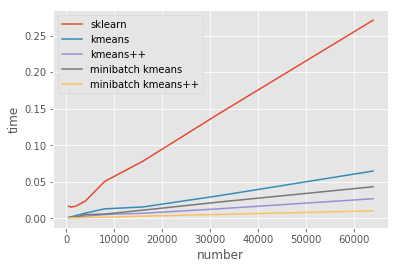

In [15]:
plt.plot(sizes, t1, label='sklearn')
plt.plot(sizes, t2, label='kmeans')
plt.plot(sizes, t3, label='kmeans++')
plt.plot(sizes, t4, label='minibatch kmeans')
plt.plot(sizes, t5, label='minibatch kmeans++')
plt.legend()
plt.xlabel('number')
plt.ylabel('time')


# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [16]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()


,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [17]:
df_sns = df_sns.drop(columns=['gradyear', 'gender', 'age', 'friends'])
df_sns.head()
X = df_sns.values.astype('float')
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

clusters_num = 9
keywords = df_sns.columns.values
batch_size = df_sns.shape[0]/30


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [18]:
## MyKMeans
km = MyKmeans(k=clusters_num)
km.fit(X)
for t, c in enumerate(km.centroids):
    print('Cluster #%d, size = %d, keywords = %s' % (t, X[km.labels == t].shape[0],
                                                     keywords[np.argsort(c)[-3:]]))


Cluster #0, size = 4597, keywords = ['music' 'band' 'die']
Cluster #1, size = 164, keywords = ['volleyball' 'sex' 'kissed']
Cluster #2, size = 957, keywords = ['soccer' 'sports' 'cheerleading']
Cluster #3, size = 688, keywords = ['drunk' 'hair' 'drugs']
Cluster #4, size = 483, keywords = ['god' 'church' 'bible']
Cluster #5, size = 90, keywords = ['god' 'jesus' 'bible']
Cluster #6, size = 547, keywords = ['cute' 'shopping' 'swimming']
Cluster #7, size = 920, keywords = ['dance' 'rock' 'hot']
Cluster #8, size = 21554, keywords = ['softball' 'tennis' 'blonde']


In [19]:
## MyKMeans++
km = MyKmeans(k=clusters_num, init='k-means')
km.fit(X)
for t, c in enumerate(km.centroids):
    print('Cluster #%d, size = %d, keywords = %s' % (t, X[km.labels == t].shape[0],
                                                     keywords[np.argsort(c)[-3:]]))


Cluster #0, size = 1456, keywords = ['cute' 'shopping' 'mall']
Cluster #1, size = 3703, keywords = ['baseball' 'tennis' 'football']
Cluster #2, size = 1937, keywords = ['kissed' 'soccer' 'drunk']
Cluster #3, size = 18310, keywords = ['bible' 'blonde' 'marching']
Cluster #4, size = 619, keywords = ['bible' 'god' 'jesus']
Cluster #5, size = 1153, keywords = ['shopping' 'abercrombie' 'hollister']
Cluster #6, size = 2032, keywords = ['basketball' 'cute' 'sexy']
Cluster #7, size = 435, keywords = ['sex' 'hair' 'hot']
Cluster #8, size = 355, keywords = ['sports' 'basketball' 'softball']


In [20]:
## MyKMeans с MiniBatchMyKMeans
km = MiniBatchKMeans(k=clusters_num, batch_size=batch_size)
km.fit(X)
for t, c in enumerate(km.centroids):
    print('Cluster #%d, size = %d, keywords = %s' % (t, X[km.labels == t].shape[0],
                                                     keywords[np.argsort(c)[-3:]]))


Cluster #0, size = 27189, keywords = ['volleyball' 'die' 'death']
Cluster #1, size = 500, keywords = ['god' 'jesus' 'church']
Cluster #2, size = 132, keywords = ['tennis' 'softball' 'shopping']
Cluster #3, size = 139, keywords = ['hollister' 'cheerleading' 'hot']
Cluster #4, size = 203, keywords = ['music' 'softball' 'rock']
Cluster #5, size = 149, keywords = ['kissed' 'hair' 'music']
Cluster #6, size = 1216, keywords = ['sports' 'baseball' 'blonde']
Cluster #7, size = 3, keywords = ['dance' 'drunk' 'drugs']
Cluster #8, size = 58, keywords = ['shopping' 'sexy' 'cute']


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in divide


In [21]:
## MyKMeans++ с MiniBatchMyKMeans
km = MiniBatchKMeans(k=clusters_num, batch_size=batch_size, init='k-means')
km.fit(X)
for t, c in enumerate(km.centroids):
    print('Cluster #%d, size = %d, keywords = %s' % (t, X[km.labels == t].shape[0],
                                                     keywords[np.argsort(c)[-3:]]))


Cluster #0, size = 22549, keywords = ['blonde' 'tennis' 'soccer']
Cluster #1, size = 232, keywords = ['die' 'sexy' 'death']
Cluster #2, size = 71, keywords = ['sports' 'basketball' 'football']
Cluster #3, size = 89, keywords = ['dance' 'marching' 'band']
Cluster #4, size = 50, keywords = ['dress' 'tennis' 'church']
Cluster #5, size = 88, keywords = ['cheerleading' 'hollister' 'abercrombie']
Cluster #6, size = 59, keywords = ['drugs' 'hair' 'kissed']
Cluster #7, size = 136, keywords = ['dance' 'dress' 'clothes']
Cluster #8, size = 70, keywords = ['god' 'baseball' 'bible']


## Вывод
Все полученные выше кластеризации, за исключением
неадекватно больших (>15000) или совсем маленьких (~10)
кластеров, хорошо интерпретируются. В целом метод k-means
исключительно сильно подвержен влиянию случайности,
что видно уже на игрушечных данных. При использовании метода
начальной инициализации k-means++ проблема становится
менее заметной, но возрастает время работы алгоритма.
Касательно модификации алгоритма MiniBatch, её использование
оправдано, так как добавляет модели гибкости в силу наличия
дополнительного гиперпараметра.